# Numerical Calculus with Gaussian Process Regression

CalcGP is an alternative to numerical integration of line integrals, and numerical differentiation of scalar valued functions.

In this notebook we how to use the package in detail via a simple one-dimensional example.

## Creating the training data sets

`jax.numpy` has almost the same usage as the standard `numpy` package, with the caveat that `jax.ndarray` is an immutable type, meaning that no inplace changes can be made. For creating training data this should however not be an issue.

In [74]:
import jax.numpy as jnp
from jax import random

We will model a simple sine function with a gradient given by a cosine function on the interval $[0, 2\pi]$:

In [75]:
def sin(x, noise=0.0, key = random.PRNGKey(0)):
    return jnp.sin(x) + random.normal(key,x.shape, dtype=jnp.float32)*noise

def cos(x, noise=0.0, key = random.PRNGKey(0)):
    return jnp.cos(x) + random.normal(key,x.shape, dtype=jnp.float32)*noise

To define the training data we first need to define boundaries to choose the datapoints from. Then, random points are chosen in this interval.

In [76]:
# Interval bounds from which to choose the data points
bounds = jnp.array([0.0, 2*jnp.pi])

# How many function and derivative observations should be chosen
n_data = (10,)

# initial seed for the pseudo random key generation
seed = 0

# create new keys and randomly sample the above interval for training features
key, subkey = random.split(random.PRNGKey(seed))
x_data = random.uniform(subkey, n_data, minval=bounds[0], maxval=bounds[1])

# noise with which to sample the training labels
noise = 0.02

key, subkey = random.split(key)
y_sin = sin(x_data,noise, subkey)
key, subkey = random.split(key)
y_cos = cos(x_data, noise, subkey)

### Defining the Kernel

Kernels describe the covariance between two input points. They are used to relate how much a function observation at point `x` will effect the prediction at another point `x_*`.

The kernels can be found in `jaxgp.kernels`. Currently implemented are `RBF`, `Linear`, and `Periodic` kernels. In general the `RBF` kernel works in most cases.

In [77]:
from calcgp.kernels import RBF

kernel = RBF()

## Integration

The goal is to take observations of cosine (`y_cos`) as the gradient and predict the sine function on the interval $[0,2\pi]$. For this purpose we additionally need a known value of sine, in order to fix the integration constant. We will take the value $sin(0)=0$ as integration constant.

In [78]:
X_train = (jnp.zeros((1,1)), x_data.reshape(-1,1))
Y_train = jnp.hstack((jnp.zeros(1), y_cos))

noise_vector = jnp.hstack((0, jnp.ones(n_data)*noise))

The $X$ points are given to the model as a tuple, were the first entry represents locations where the function was observed and the second entry represents locations were the gradient was observed.

For $Y$ the idea is the same but the points are stacked in a single 1-d array.

In our case the data is of the form

```{python}
    X_train = (0, x_data)
    Y_train = (sin(0), cos(x_data) + N(0,1)noise)
```

Lastly `noise_vec` represents the noise present in the training data. Since we know the value of $sin(0)$ exactly, it has zero noise. All other values have the noise defined as above.

The model to do integration is called `FullIntegral`. When initializing, one only needs to specify the kernel function and the noise. There is also the possibility to optimize the value of the noise, but this is deactivated by default.

In [79]:
from calcgp import FullIntegral

model = FullIntegral(kernel, noise=noise_vector)

In [80]:
model.train(X_train, Y_train)

True


After the training we can simply call `model.predict` and it returns the predicted function values as well as a confidence interval at the chosen locations. The confidince interval given describes a $1\sigma$ confidence on where the true function values lie.

In [81]:
predict_grid = jnp.linspace(*bounds, 100)

int_pred, int_err = model.predict(predict_grid.reshape(-1,1))

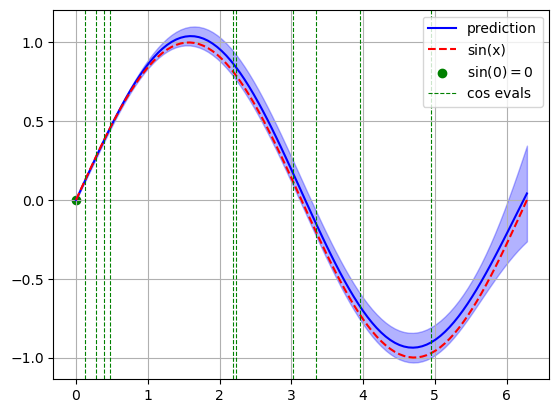

In [82]:
import matplotlib.pyplot as plt

plt.plot(predict_grid, int_pred, c="b", label="prediction")
plt.fill_between(predict_grid, int_pred-int_err*2, int_pred+int_err*2, color="b", alpha=0.3)

plt.plot(predict_grid, sin(predict_grid), c="r", ls="--",label="sin(x)")

plt.scatter(0, 0, c="g", label="$\sin(0)=0$")
for i,x in enumerate(x_data): 
    if i == 0:
        plt.axvline(x, c="g", lw=0.8, ls="--", label="cos evals")
    else:
        plt.axvline(x, c="g", lw=0.8, ls="--")

plt.grid()
plt.legend()

The plot above shows the predicted function from the given data in blue. The shaded area is the 95%-confidence interval in which the true function lies. The green dashed vertical lines describe the positions at which the gradient was sampled with noise.

## Differentiation

We again take evaluations of cosine (`y_cos`) as our data. However this time we want to predict the gradient from this data. This can be done via the `FullGradient` model. Here we don't use any known value of the gradient, however, if this knowledge exists it can be helpful when adding this.

If we don't have both gradient and function values, then there is no need to create a tuple of data for `X_train`. However, if we want to add a point were the gradient was observed then we again need a tuple, and the data must be given in the order (function observations, gradient observations).

In [83]:
X_train = x_data.reshape(-1,1)
Y_train = y_cos

from calcgp import FullGradient

model = FullGradient(kernel, noise=noise)

In [84]:
model.train(X_train, Y_train)
grad_pred, grad_err = model.predict(predict_grid.reshape(-1,1))

grad_pred = grad_pred.reshape(-1)
grad_err = grad_err.reshape(-1)

True


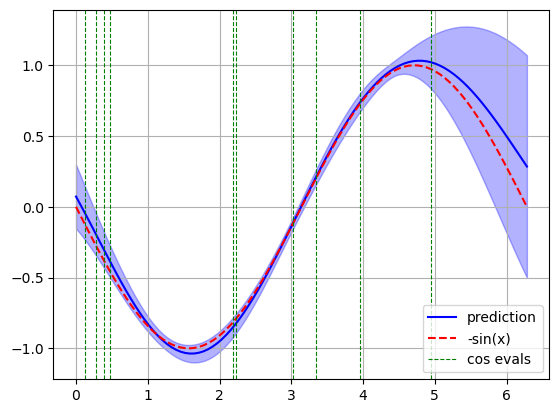

In [85]:
import matplotlib.pyplot as plt

plt.plot(predict_grid, grad_pred, c="b", label="prediction")
plt.fill_between(predict_grid, grad_pred-grad_err*2, grad_pred+grad_err*2, color="b", alpha=0.3)

plt.plot(predict_grid, -sin(predict_grid), c="r", ls="--",label="-sin(x)")

for i,x in enumerate(x_data): 
    if i == 0:
        plt.axvline(x, c="g", lw=0.8, ls="--", label="cos evals")
    else:
        plt.axvline(x, c="g", lw=0.8, ls="--")

plt.grid()
plt.legend()

We again have the predicted function in blue, with the shaded area representing the 95%-confidence interval. This plot shows, that far away from the given datapoints the confidence interval becomes very large.

## Simple Regression

Lastly, it is also possible to just predict a function from its own observations. This can also sometimes be useful, so we added this to the package. To show this, we again use `y_cos` to fit cosine directly.

The data input still looks the same as above and the model to use now is called `FullFunction`.

Here, instead of providing the noise that we expect in the data, we instead let the model optimize the noise parameter directly.

In [86]:
X_train = x_data.reshape(-1,1)
Y_train = y_cos

from calcgp import FullFunction

model = FullFunction(kernel, optim_noise=True)#noise=noise)

In [87]:
model.train(X_train, Y_train)
fun_pred, fun_err = model.predict(predict_grid.reshape(-1,1))

fun_pred = fun_pred.reshape(-1)
fun_err = fun_err.reshape(-1)

True


In [93]:
print(f"optimized noise = {model.noise:.3f}")

optimized noise = 0.011


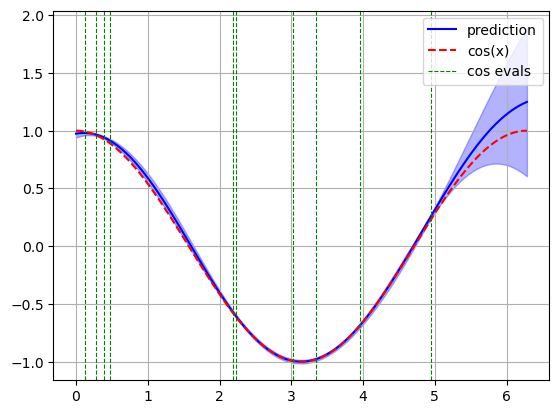

In [89]:
import matplotlib.pyplot as plt

plt.plot(predict_grid, fun_pred, c="b", label="prediction")
plt.fill_between(predict_grid, fun_pred-fun_err*2, fun_pred+fun_err*2, color="b", alpha=0.3)

plt.plot(predict_grid, cos(predict_grid), c="r", ls="--",label="cos(x)")

for i,x in enumerate(x_data): 
    if i == 0:
        plt.axvline(x, c="g", lw=0.8, ls="--", label="cos evals")
    else:
        plt.axvline(x, c="g", lw=0.8, ls="--")

plt.grid()
plt.legend()